>>> 0. 라이브러리 설치 중...
Using device: cuda

>>> 1. ControlNet (Canny) 모델 로드 중... (1.4GB)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

>>> ControlNet-Canny 로드 완료.

>>> 2. Stable Diffusion v1.5 모델 로드 중... (1.7GB)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


>>> Stable Diffusion 로드 완료.

>>> 3. 원본 스케치 이미지 로드 완료.
--- 원본 스케치 ---


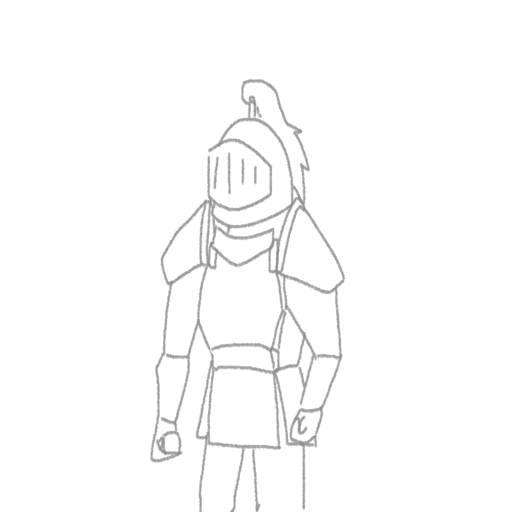


>>> 4. 스케치에서 'Canny 외곽선' 추출 중...
--- [1단계 결과] ControlNet이 참고할 외곽선 ---


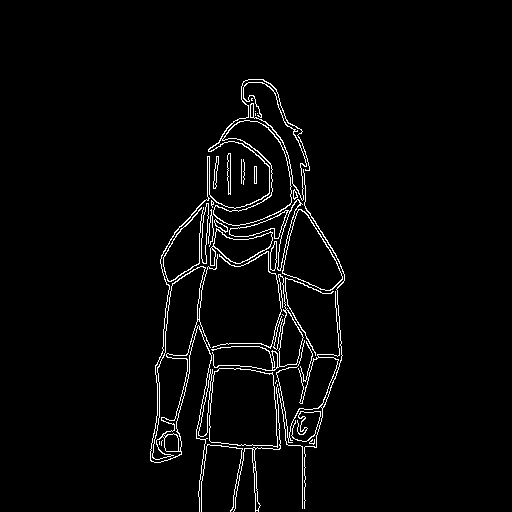


>>> 5. [2단계] 스케치와 프롬프트로 이미지 생성 중...


  0%|          | 0/30 [00:00<?, ?it/s]


>>> 6. ✨ 컨셉 아트 생성 완료 ✨


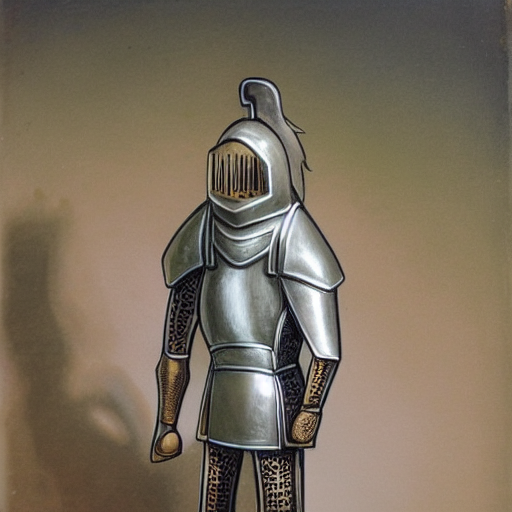

In [1]:
# @title [제안 1: AI 컨셉 아트 어시스턴트 (스케치 -> 완성)]
# (런타임 다시 시작 후 이 셀을 '단 한 번만' 실행하세요)

# --- 0. 라이브러리 설치 ---
print(">>> 0. 라이브러리 설치 중...")
# ControlNet에 필요한 OpenCV(cv2)를 함께 설치합니다.
!pip install --upgrade transformers diffusers accelerate "pillow<12.0" opencv-python-headless --quiet
import torch
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
from PIL import Image
import cv2 # OpenCV
import numpy as np

# GPU 사용 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cpu":
    print("WARNING: GPU가 설정되지 않았습니다. [런타임] > [런타임 유형 변경]에서 'T4 GPU'를 선택하세요.")


# --- 1. ControlNet (Canny) 모델 로드 ---
# (Canny는 '스케치'나 '낙서'의 외곽선을 감지하는 데 가장 좋습니다)
print("\n>>> 1. ControlNet (Canny) 모델 로드 중... (1.4GB)")
try:
    controlnet = ControlNetModel.from_pretrained(
        "lllyasviel/sd-controlnet-canny",
        torch_dtype=torch.float16
    )
    print(">>> ControlNet-Canny 로드 완료.")
except Exception as e:
    print(f"ControlNet 로드 실패: {e}")
    raise e

# --- 2. Stable Diffusion (기본) 모델 로드 ---
print("\n>>> 2. Stable Diffusion v1.5 모델 로드 중... (1.7GB)")
model_id = "runwayml/stable-diffusion-v1-5"
try:
    pipe = StableDiffusionControlNetPipeline.from_pretrained(
        model_id,
        controlnet=controlnet,
        torch_dtype=torch.float16,
        safety_checker=None
    ).to(device)

    pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
    print(">>> Stable Diffusion 로드 완료.")
except Exception as e:
    print(f"Stable Diffusion 로드 실패 (VRAM 부족 가능성): {e}")
    raise e


# --- 3. 원본 '스케치' 이미지 준비 ---

# ★ [핵심] 테스트용 '스케치' 이미지 URL입니다.
# (사용자님이 직접 그린 스케치(예: 'mysketch.png')를 업로드하고 경로를 바꿔도 됩니다)
image_url = "test_knight.jpg"
original_image = load_image(image_url).resize((512, 512))

print("\n>>> 3. 원본 스케치 이미지 로드 완료.")
print("--- 원본 스케치 ---")
display(original_image)

# --- 4. [1단계] 스케치에서 '외곽선' 추출 (Canny) ---
# ControlNet이 참고할 가이드라인을 만듭니다.
print("\n>>> 4. 스케치에서 'Canny 외곽선' 추출 중...")
image_np = np.array(original_image)
canny_image = cv2.Canny(image_np, 100, 200) # Canny 알고리즘 실행
canny_image = Image.fromarray(canny_image)

print("--- [1단계 결과] ControlNet이 참고할 외곽선 ---")
display(canny_image)


# --- 5. [2단계] 프롬프트로 '완성' 이미지 생성 ---
# ★ [핵심] 이 스케치를 '무엇으로' 채울지 지시합니다.
prompt = "dark knight, **black rusty armor**, glowing red eyes, fantasy art"
negative_prompt = "blurry, low quality, unrealistic, watermarks, text, deformed"

print("\n>>> 5. [2단계] 스케치와 프롬프트로 이미지 생성 중...")

generator = torch.manual_seed(12345)
result_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=canny_image, # ★ Canny 외곽선을 '가이드'로 전달
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]


# --- 6. 최종 결과물 표시 ---
print("\n>>> 6. ✨ 컨셉 아트 생성 완료 ✨")
display(result_image)


>>> 5. [2단계] 스케치와 프롬프트로 이미지 생성 중...


  0%|          | 0/30 [00:00<?, ?it/s]


>>> 6. ✨ 컨셉 아트 생성 완료 ✨


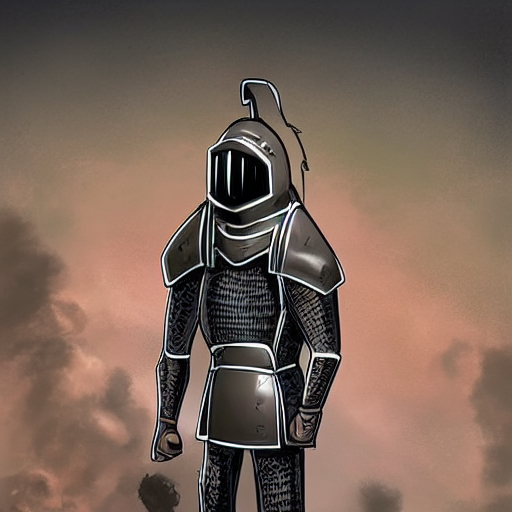

In [5]:
# --- 5. [2단계] 프롬프트로 '완성' 이미지 생성 ---
# ★ [핵심] 이 스케치를 '무엇으로' 채울지 지시합니다.
prompt = "a knight in **full black iron plate armor**, **black iron arms**, **black iron shoulder pauldrons**, **brown leather gloves (gauntlets)**, **red plume on the helmet**, detailed, fantasy art, medieval"
negative_prompt = "blurry, low quality, deformed, distorted, shining armor, silver, gold, rust, watermark, text, **leather arms**, **fabric arms**, exposed skin on arms"

print("\n>>> 5. [2단계] 스케치와 프롬프트로 이미지 생성 중...")

generator = torch.manual_seed(12345)
result_image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=canny_image, # ★ Canny 외곽선을 '가이드'로 전달
    num_inference_steps=30,
    guidance_scale=7.5,
    generator=generator
).images[0]


# --- 6. 최종 결과물 표시 ---
print("\n>>> 6. ✨ 컨셉 아트 생성 완료 ✨")
display(result_image)